In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sap
import rasterio as rio

In [18]:
# ! wget 'https://oin-hotosm-temp.s3.us-east-1.amazonaws.com/669a3a711684770001c33a8f/0/669a3a711684770001c33a90.tif' -O drone_image_1.tif

In [19]:
def load_drone_image(filename, band=1):
    with rio.open(filename) as src:
        img = src.read(band)
        img = img.astype(np.float32)
        img = (img - img.min()) / (img.max() - img.min())
        return img

In [20]:
img = load_drone_image('drone_image_1.tif')

In [21]:
## max-tree and attributes 

max_tree = sap.MaxTree(img)
area = max_tree.get_attribute('area')
compactness = max_tree.get_attribute('compactness')
moi = max_tree.get_attribute('moment_of_inertia')
print(f'Nodes: {max_tree.num_nodes()}')
print(f'Area: [{area.min():.0f}, {area.max():.0f}]')
print(f'Compactness: [{compactness.min():.3f}, {compactness.max():.3f}]')
print(f'MOI: [{moi.min():.3f}, {moi.max():.3f}]')

Nodes: 69919229
Area: [1, 62051395]
Compactness: [0.000, 1.000]
MOI: [0.000, 18.448]


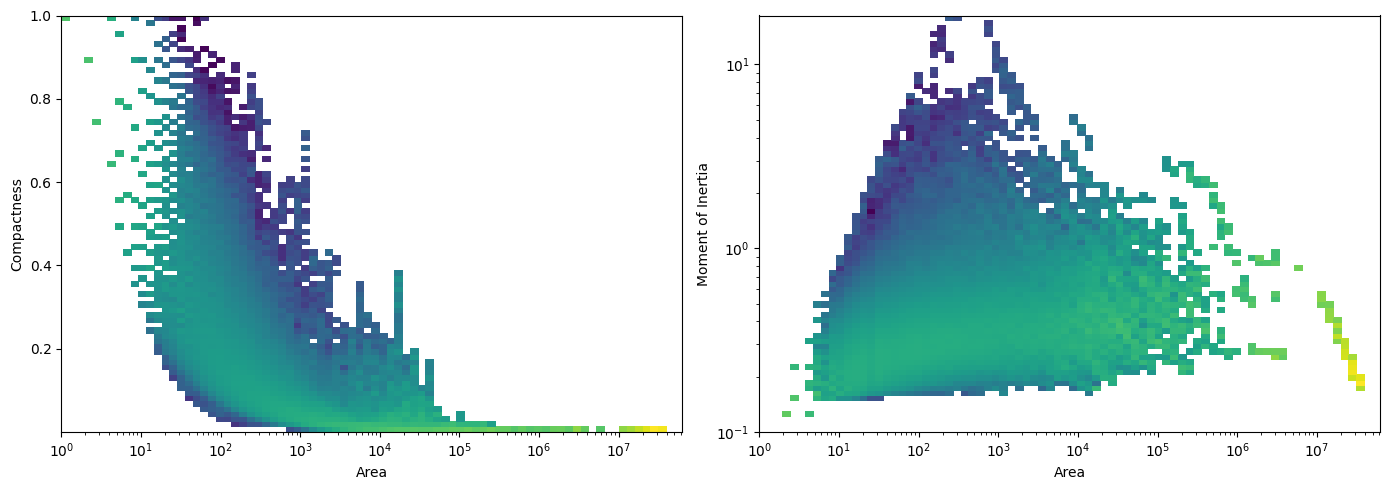

In [22]:
## 2D Pattern Spectra
s_ac, xe_ac, ye_ac, xl_ac, yl_ac = sap.spectrum2d(max_tree, 'area', 'compactness', x_count=80, y_count=80, x_log=True)
s_am, xe_am, ye_am, xl_am, yl_am = sap.spectrum2d(max_tree, 'area', 'moment_of_inertia', x_count=80, y_count=80, x_log=True, y_log=True)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sap.show_spectrum(s_ac, xe_ac, ye_ac, xl_ac, yl_ac, log_scale=True)
plt.xlabel('Area')
plt.ylabel('Compactness')
plt.subplot(1, 2, 2)
sap.show_spectrum(s_am, xe_am, ye_am, xl_am, yl_am, log_scale=True)
plt.xlabel('Area')
plt.ylabel('Moment of Inertia')
plt.tight_layout()
plt.show()

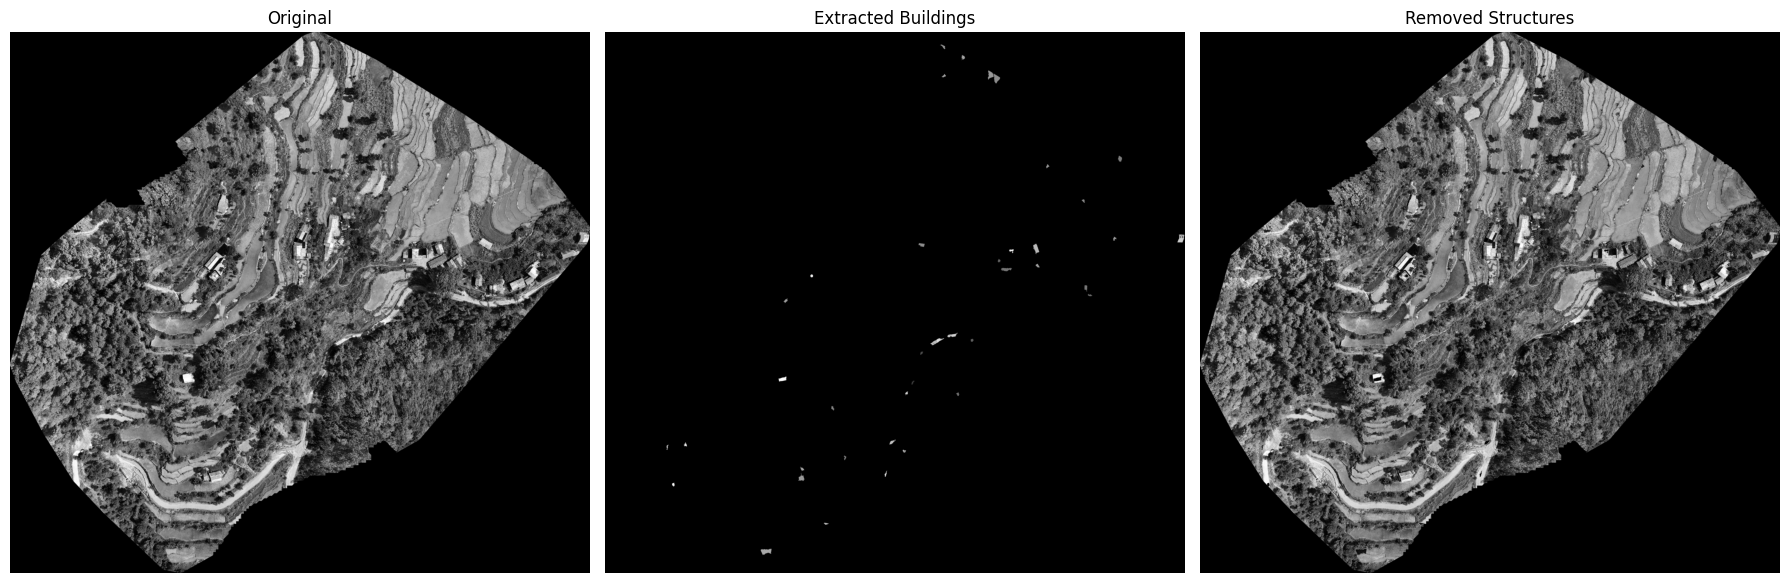

Selected 532/69919229 nodes (0.0%)


In [25]:
## building extraction
area_min, area_max = 1000, 10000
comp_min = 0.20
moi_max = 3000

mask = (area >= area_min) & (area <= area_max) & (compactness >= comp_min) & (moi <= moi_max)
filtered = max_tree.reconstruct(~mask)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(filtered, cmap='gray')
axes[1].set_title('Extracted Buildings')
axes[1].axis('off')
axes[2].imshow(img - filtered, cmap='gray')
axes[2].set_title('Removed Structures')
axes[2].axis('off')
plt.tight_layout()
plt.show()
print(f'Selected {mask.sum()}/{len(mask)} nodes ({100*mask.sum()/len(mask):.1f}%)')


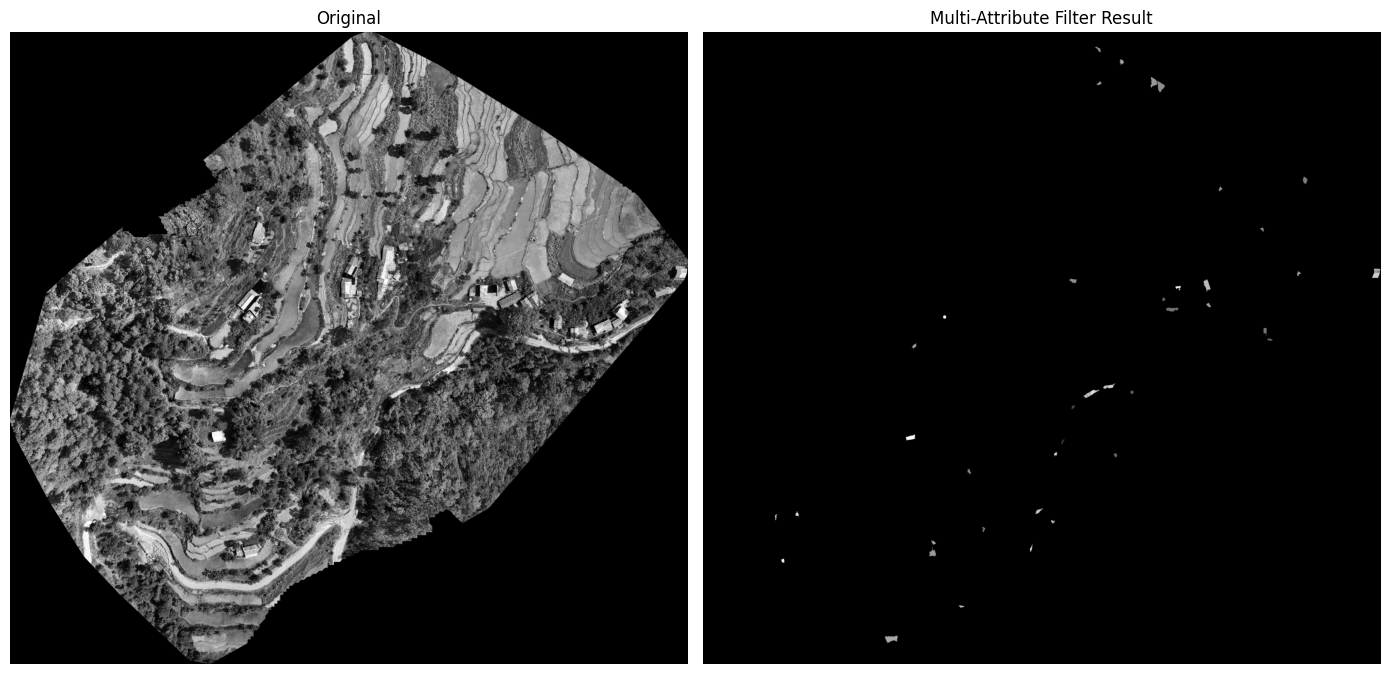

Nodes: 532/69919229


In [26]:
def multi_attribute_filter(tree, thresholds):
    """Filter tree nodes using multiple attribute thresholds.
    
    Parameters
    
    tree : sap.Tree
        Input tree
    thresholds : dict
        Dict of {attr_name: (min_val, max_val)}
    
    Returns
    
    mask : ndarray
        Boolean mask of nodes meeting all criteria
    """
    mask = np.ones(tree.num_nodes(), dtype=bool)
    for attr, (min_val, max_val) in thresholds.items():
        vals = tree.get_attribute(attr)
        mask &= (vals >= min_val) & (vals <= max_val)
    return mask

thresholds = {'area': (area_min, area_max), 'compactness': (comp_min, 1.0), 'moment_of_inertia': (0, moi_max)}
mask_adv = multi_attribute_filter(max_tree, thresholds)
filtered_adv = max_tree.reconstruct(~mask_adv)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(filtered_adv, cmap='gray')
axes[1].set_title('Multi-Attribute Filter Result')
axes[1].axis('off')
plt.tight_layout()
plt.show()
print(f'Nodes: {mask_adv.sum()}/{len(mask_adv)}')